In [166]:
import config as c
import utils as u

import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context("paper")
%load_ext autoreload
%autoreload 2


STAGE_LABELS = ["Side Poke", "Fixation Growth", "Probe"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. Load Data


In [164]:
tdf = u.load_trials_df(stages="all")

ddf = u.load_days_df(stages="all")

Loading trials data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication
Loading days data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


## 0.1 Add Stage Type Column


In [170]:
# Define the conditions and corresponding stage types.
def add_stage_type_column(df):
    choices = ["spoke", "grow_fix", "probe"]
    conditions = [
        (df["stage"] >= 1) & (df["stage"] <= 4),
        (df["stage"] >= 5) & (df["stage"] <= 8),
        (df["stage"] >= 9) & (df["stage"] <= 10),
    ]

    # Use np.select to create the new column.
    df["stage_type"] = np.select(conditions, choices, default=pd.NA)

    # Raise an error if any stage does not fall into the expected ranges.
    if df["stage_type"].isnull().any():
        invalid_stages = df.loc[df["stage_type"].isnull(), "stage"].unique()
        raise ValueError(f"Unexpected stage values encountered: {invalid_stages}")

    return df


# Apply the function to tdf
tdf = add_stage_type_column(tdf)
ddf = add_stage_type_column(ddf)

## 0.2 Functions


In [121]:
"""Box Strip Plot"""

import seaborn as sns


def box_strip_v1_vs_v2(
    data,
    x,
    order,
    y,
    ax,
    hue_type="experiment",
    alpha=0.75,
    ylabel=None,
    xlabel=None,
    **kwargs,
):
    sns.despine()

    sns.boxplot(
        x=x,
        y=y,
        data=data,
        order=order,
        ax=ax,
        hue="fix_experiment",
        hue_order=["V1", "V2"],
        palette=c.EXP_PALETTE,
        fill=None,
        showfliers=False,
        dodge=True,
        **kwargs,
    )

    if hue_type == "animal":
        hue = "animal_id"
        hue_order = c.HUE_ORDER_ANIMALS
        palette = c.ANIMAL_PALETTE
    else:
        hue = "fix_experiment"
        hue_order = ["V1", "V2"]
        palette = c.EXP_PALETTE

    sns.stripplot(
        x=x,
        y=y,
        data=data,
        order=order,
        ax=ax,
        hue=hue,
        hue_order=hue_order,
        palette=palette,
        dodge=True,
        legend=False,
        alpha=alpha,
        **kwargs,
    )

    ax.legend(title=None, frameon=False)

    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xlabel is not None:
        ax.set_xlabel(xlabel)

In [118]:
"""Stats for comparing V1 and V2, single sample"""

import numpy as np
import pandas as pd
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests


def check_normality(data, alpha=0.05):
    """
    Returns True if data passes the Shapiro–Wilk test for normality
    at the specified alpha level, False otherwise.
    """
    stat, p = shapiro(data)
    return p >= alpha


def compare_two_groups(v1_values, v2_values, alpha=0.05):
    """
    Given two arrays of values (V1 and V2), checks normality in each group.
    If both pass, runs Welch's t-test. Otherwise, runs Mann–Whitney U.
    Returns a dict with test results:
    {
      'test_type': str ('welch_t' or 'mannwhitney'),
      'test_statistic': float,
      'p_val_raw': float,
      'normality_V1': bool,
      'normality_V2': bool,
      'n_V1': int,
      'n_V2': int
    }
    """
    normal_v1 = check_normality(v1_values, alpha=alpha)
    normal_v2 = check_normality(v2_values, alpha=alpha)

    results = {
        "normality_V1": normal_v1,
        "normality_V2": normal_v2,
        "n_V1": len(v1_values),
        "n_V2": len(v2_values),
    }

    if normal_v1 and normal_v2:
        # Use Welch’s t-test (two-sample, unequal variance)
        stat, p_val = ttest_ind(v1_values, v2_values, equal_var=False)
        results["test_type"] = "welch_t"
        results["test_statistic"] = stat
        results["p_val_raw"] = p_val
    else:
        # Use Mann–Whitney U for non-normal data
        stat, p_val = mannwhitneyu(v1_values, v2_values, alternative="two-sided")
        results["test_type"] = "mannwhitney"
        results["test_statistic"] = stat
        results["p_val_raw"] = p_val

    return results


def compare_v1_v2_by_stage(df, metric_col, alpha=0.05):
    """
    Main function to:
      1) Subset the DataFrame by the three known stages ('spoke', 'grow_fix', 'probe').
      2) For each stage, compare 'V1' vs 'V2' using either Welch’s t-test or Mann–Whitney U,
         depending on normality checks.
      3) Collect raw p-values for the three tests, apply Holm–Bonferroni correction.
      4) Return a tidy DataFrame with columns:
         ['stage','test_type','test_statistic','p_val_raw','p_val_adj','reject_H0',
          'normality_V1','normality_V2','n_V1','n_V2'].
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns:
            'stage_type' (with exactly 'spoke', 'grow_fix', 'probe'),
            'fix_experiment' (with 'V1' or 'V2'),
            and metric_col (the numeric variable to compare).
    metric_col : str
        The numeric variable to compare (e.g. n_days_in_stage_type)
    alpha : float, optional
        Significance level for both normality checks and final threshold (default 0.05).

    Returns
    -------
    pd.DataFrame
        Summary of test results for each stage.
    """
    # We know we have exactly these three stages
    stages = ["spoke", "grow_fix", "probe"]
    results_list = []

    for st in stages:
        # Subset DataFrame to the specific stage
        df_stage = df[df["stage_type"] == st].copy()

        # Extract data for V1, V2
        v1_data = df_stage.loc[
            df_stage["fix_experiment"] == "V1", metric_col
        ].to_numpy()
        v2_data = df_stage.loc[
            df_stage["fix_experiment"] == "V2", metric_col
        ].to_numpy()

        # Compare the two groups
        stage_result = compare_two_groups(v1_data, v2_data, alpha=alpha)
        stage_result["stage"] = st
        results_list.append(stage_result)

    # Convert results into a DataFrame
    results_df = pd.DataFrame(results_list)
    # We have raw p-values in the column 'p_val_raw'
    pvals = results_df["p_val_raw"].values

    # Apply Holm–Bonferroni correction (less conservative than Bonferroni)
    reject_mask, p_vals_adj, _, _ = multipletests(pvals, alpha=alpha, method="holm")
    results_df["p_val_adj"] = p_vals_adj
    results_df["reject_H0"] = reject_mask

    # Order columns
    col_order = [
        "stage",
        "test_type",
        "test_statistic",
        "p_val_raw",
        "p_val_adj",
        "reject_H0",
        "normality_V1",
        "normality_V2",
        "n_V1",
        "n_V2",
    ]
    results_df = results_df[col_order]
    return results_df

In [120]:
"""Stats for comparing V1 and V2, multi-sample """

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from scipy.stats import shapiro


def check_normality(data, alpha=0.05):
    """
    Returns True if data passes the Shapiro–Wilk test for normality
    at the specified alpha level, False otherwise.
    """
    stat, p = shapiro(data)
    return p >= alpha


def compare_v1_v2_by_stage_multi_sample(
    df, metric_col, alpha=0.05, correction_method="holm"
):
    """
    For each unique stage_type in the DataFrame, fit a simple linear mixed-effects model:
       metric_col ~ fix_experiment + (1|animal_id)

    Steps:
      1. Subset data by each stage.
      2. Fit a random-intercept mixed model comparing V1 vs. V2.
      3. Extract the test statistic and p-value for fix_experiment[T.V2].
      4. Check the normality of model residuals via Shapiro–Wilk.
      5. Apply multiple-comparison correction to the p-values.
      6. Return a tidy DataFrame summarizing the results.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns: ['animal_id', 'fix_experiment', 'stage_type', metric_col].
        'fix_experiment' should have 'V1' or 'V2'.
    metric_col : str
        The numeric column to compare (e.g., "hit_rate").
    alpha : float, optional
        Significance level, used for final threshold after correction and normality checks.
        Default is 0.05.
    correction_method : str, optional
        Method for p-value correction (see statsmodels.stats.multitest.multipletests).
        Defaults to 'holm'.

    Returns
    -------
    pd.DataFrame
        Tidy DataFrame with columns:
        ['stage', 'test_type', 'test_statistic', 'p_val_raw', 'p_val_adj',
         'residuals_normal', 'reject_H0']

        One row per stage_type in the original DataFrame.
    """
    required_cols = ["animal_id", "fix_experiment", "stage_type", metric_col]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"DataFrame is missing required column: '{col}'")

    stage_types = df["stage_type"].unique()
    results_list = []

    for stage in stage_types:
        # Subset & reset index to avoid indexing issues
        stage_df = df[df["stage_type"] == stage].dropna(subset=[metric_col]).copy()
        stage_df.reset_index(drop=True, inplace=True)

        # Check if both groups exist in this stage
        v1_df = stage_df[stage_df["fix_experiment"] == "V1"]
        v2_df = stage_df[stage_df["fix_experiment"] == "V2"]
        if v1_df.empty or v2_df.empty:
            continue  # No comparison if one group is missing

        # Fit the mixed model: metric_col ~ fix_experiment
        model = smf.mixedlm(
            formula=f"{metric_col} ~ fix_experiment",
            data=stage_df,
            groups=stage_df["animal_id"],  # random intercept by animal_id
        )
        try:
            model_fit = model.fit(method="lbfgs", disp=False)
        except Exception as e:
            print(f"Model failed for stage {stage} with error: {e}")
            continue

        # Extract the coefficient info for V2 vs. V1
        coef_key = "fix_experiment[T.V2]"
        if coef_key not in model_fit.params.index:
            # If there's no variance or the model can't estimate that coefficient, skip
            continue

        t_val = model_fit.tvalues[coef_key]
        p_val = model_fit.pvalues[coef_key]

        # Check normality of residuals
        residuals = model_fit.resid  # Alternatively model_fit.resid_response
        residuals_are_normal = check_normality(residuals, alpha=alpha)

        results_list.append(
            {
                "stage": stage,
                "test_type": "mixedlm_random_intercept",
                "test_statistic": t_val,
                "p_val_raw": p_val,
                "residuals_normal": residuals_are_normal,
            }
        )

    # If no valid results, return an empty DataFrame
    if not results_list:
        return pd.DataFrame(
            columns=[
                "stage",
                "test_type",
                "test_statistic",
                "p_val_raw",
                "p_val_adj",
                "residuals_normal",
                "reject_H0",
            ]
        )

    results_df = pd.DataFrame(results_list)

    # Multiple-comparison correction
    reject_array, pvals_corrected, _, _ = multipletests(
        results_df["p_val_raw"], alpha=alpha, method=correction_method
    )
    results_df["p_val_adj"] = pvals_corrected
    results_df["reject_H0"] = reject_array

    # Order columns for a tidy look
    col_order = [
        "stage",
        "test_type",
        "test_statistic",
        "p_val_raw",
        "p_val_adj",
        "residuals_normal",
        "reject_H0",
    ]
    results_df = results_df[col_order]

    return results_df

# 1. N Days in Stage Type


In [72]:
stage_type_summary_df = (
    tdf.groupby(["animal_id", "fix_experiment", "stage_type"])["date"]
    .nunique()
    .reset_index(name="n_days_in_stage_type")
)

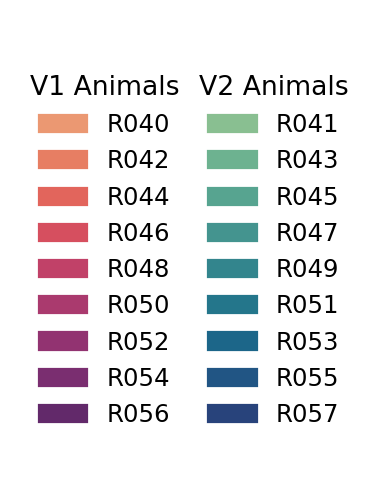

In [285]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create legend handles for V1 and V2 animals separately
handles_v1 = [
    mpatches.Patch(color=c.ANIMAL_PALETTE[animal], label=animal)
    for animal in c.V1_ANIMALS
]
handles_v2 = [
    mpatches.Patch(color=c.ANIMAL_PALETTE[animal], label=animal)
    for animal in c.V2_ANIMALS
]

# Create a dummy plot to display the legend
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2, 3), dpi=200)

# Add legends to the subplots
ax1.legend(handles=handles_v1, title="V1 Animals", loc="center", frameon=False)
ax2.legend(handles=handles_v2, title="V2 Animals", loc="center", frameon=False)

# Hide axes
ax1.axis("off")
ax2.axis("off")

plt.show()

Text(0.5, 1.0, 'Number of Days in Stage Type')

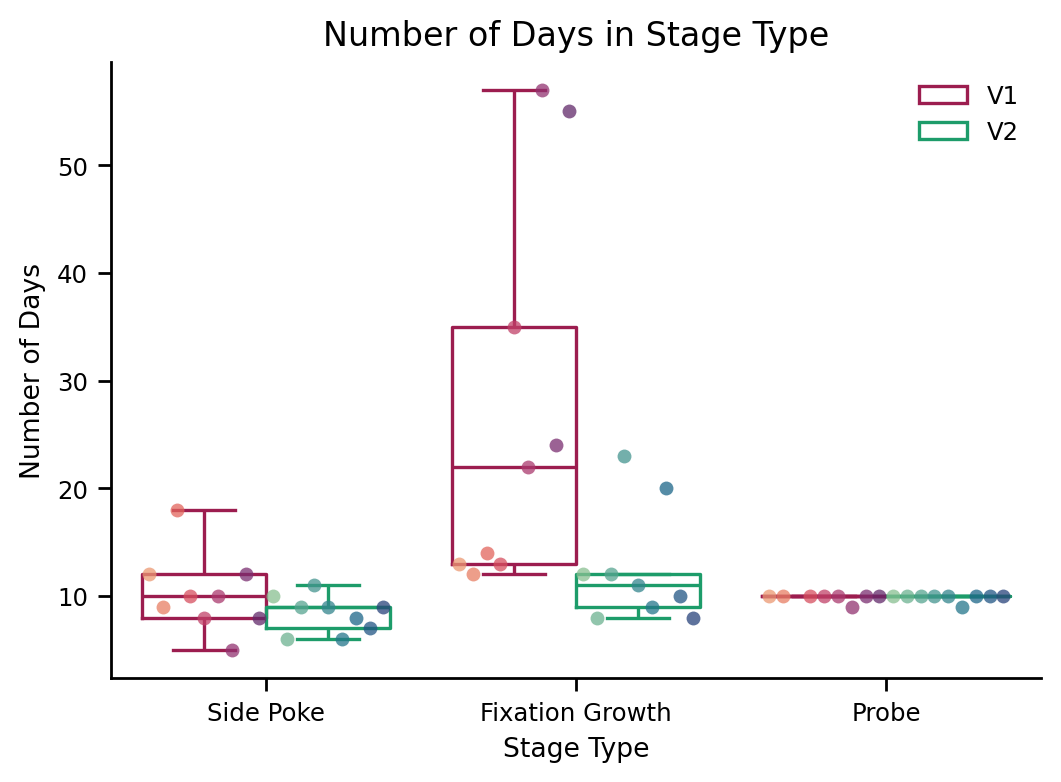

In [287]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

box_strip_v1_vs_v2(
    stage_type_summary_df,
    x="stage_type",
    order=["spoke", "grow_fix", "probe"],
    y="n_days_in_stage_type",
    hue_type="animal",
    ax=ax,
    xlabel="Stage Type",
    ylabel="Number of Days",
)

_ = ax.set_xticks([0, 1, 2])
_ = ax.set_xticklabels(STAGE_LABELS)
ax.set_title("Number of Days in Stage Type", fontsize=12)

In [76]:
compare_v1_v2_by_stage(stage_type_summary_df, metric_col="n_days_in_stage_type")

,stage,test_type,test_statistic,p_val_raw,p_val_adj,reject_H0,normality_V1,normality_V2,n_V1,n_V2
0,spoke,welch_t,1.408136,0.185638,0.371277,False,True,True,9,9
1,grow_fix,mannwhitney,71.000000,0.007877,0.023630,True,False,False,9,9
2,probe,mannwhitney,35.500000,1.000000,1.000000,False,False,False,8,9


# 2. Hit Rate, No Answer Rate


## 2.1 Hit Rate


In [101]:
hit_rate_df = (
    tdf.groupby(["animal_id", "fix_experiment", "stage_type", "date"])["hits"]
    .mean()
    .reset_index(name="hit_rate")
)

hit_rate_df.head()

,animal_id,fix_experiment,stage_type,date,hit_rate
0,R040,V1,grow_fix,2024-08-01,0.984615
1,R040,V1,grow_fix,2024-08-02,0.980328
2,R040,V1,grow_fix,2024-08-03,0.988764
3,R040,V1,grow_fix,2024-08-04,0.97493
4,R040,V1,grow_fix,2024-08-05,0.990132


Text(0.5, 1.0, 'Hit Rate by Stage Type')

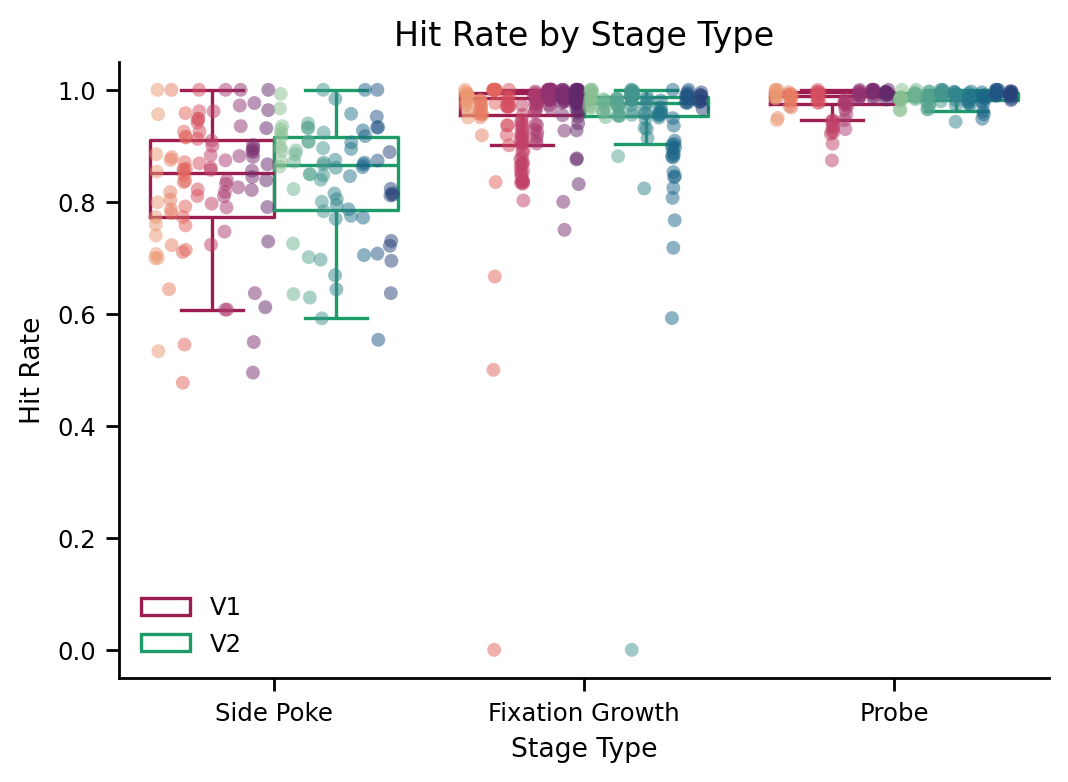

In [289]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

box_strip_v1_vs_v2(
    hit_rate_df,
    x="stage_type",
    order=["spoke", "grow_fix", "probe"],
    y="hit_rate",
    ax=ax,
    hue_type="animal",
    alpha=0.5,
    ylabel="Hit Rate",
    xlabel="Stage Type",
)

_ = ax.set_xticks([0, 1, 2])
_ = ax.set_xticklabels(STAGE_LABELS)
ax.set_title("Hit Rate by Stage Type", fontsize=12)

In [103]:
compare_v1_v2_by_stage_multi_sample(hit_rate_df, metric_col="hit_rate")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWar

,stage,test_type,test_statistic,p_val_raw,p_val_adj,residuals_normal,reject_H0
0,grow_fix,mixedlm_random_intercept,0.104080,0.917106,1.0,False,False
1,probe,mixedlm_random_intercept,0.962820,0.335638,1.0,False,False
2,spoke,mixedlm_random_intercept,0.370288,0.711168,1.0,False,False


In [113]:
summary_hit = (
    hit_rate_df.groupby(["animal_id", "stage_type", "fix_experiment"])["hit_rate"]
    .mean()
    .reset_index()
)
compare_v1_v2_by_stage(summary_hit, metric_col="hit_rate")

,stage,test_type,test_statistic,p_val_raw,p_val_adj,reject_H0,normality_V1,normality_V2,n_V1,n_V2
0,spoke,welch_t,-0.079755,0.937453,1.0,False,True,True,9,9
1,grow_fix,mannwhitney,40.000000,1.000000,1.0,False,False,False,9,9
2,probe,mannwhitney,36.000000,1.000000,1.0,False,False,True,8,9


## 2.2 No Answer Rate


In [ ]:
no_answer_rate_df = (
    tdf.groupby(["animal_id", "date", "stage_type", "fix_experiment"])["result"]
    .apply(lambda x: (x == 6).mean())
    .reset_index(name="no_answer_rate")
)
no_answer_rate_df.head()

Text(0.5, 1.0, 'No Answer Rate by Stage Type')

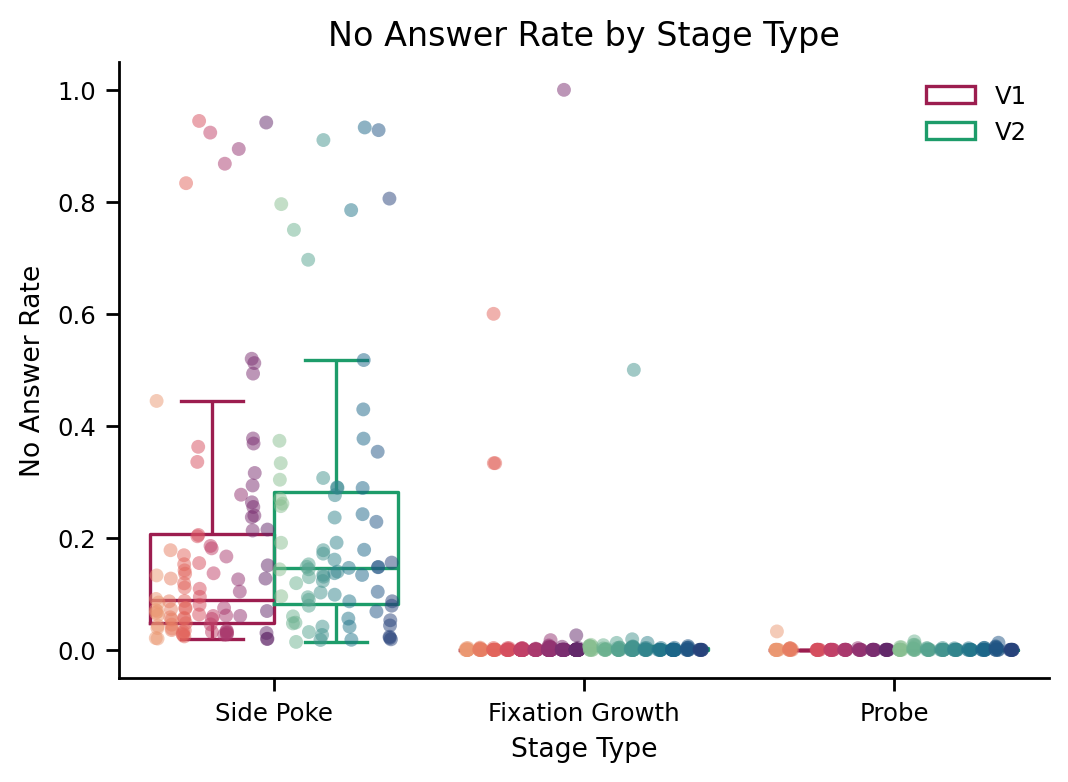

In [290]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

box_strip_v1_vs_v2(
    no_answer_rate_df,
    x="stage_type",
    order=["spoke", "grow_fix", "probe"],
    y="no_answer_rate",
    ax=ax,
    hue_type="animal",
    alpha=0.5,
    ylabel="No Answer Rate",
    xlabel="Stage Type",
)

_ = ax.set_xticks([0, 1, 2])
_ = ax.set_xticklabels(STAGE_LABELS)
ax.set_title("No Answer Rate by Stage Type", fontsize=12)

In [109]:
compare_v1_v2_by_stage_multi_sample(no_answer_rate_df, metric_col="no_answer_rate")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: R

,stage,test_type,test_statistic,p_val_raw,p_val_adj,residuals_normal,reject_H0
0,spoke,mixedlm_random_intercept,1.037331,0.299582,0.898745,False,False
1,grow_fix,mixedlm_random_intercept,-0.507635,0.611709,0.898745,False,False
2,probe,mixedlm_random_intercept,0.903174,0.366434,0.898745,False,False


In [114]:
summary_no_answer = (
    no_answer_rate_df.groupby(["animal_id", "stage_type", "fix_experiment"])[
        "no_answer_rate"
    ]
    .mean()
    .reset_index())
)
compare_v1_v2_by_stage(summary_no_answer, metric_col="no_answer_rate")

,stage,test_type,test_statistic,p_val_raw,p_val_adj,reject_H0,normality_V1,normality_V2,n_V1,n_V2
0,spoke,welch_t,-0.910146,0.376515,0.753029,False,True,True,9,9
1,grow_fix,mannwhitney,36.000000,0.723932,0.753029,False,False,False,9,9
2,probe,mannwhitney,21.500000,0.168511,0.505532,False,False,False,8,9


# 3. Trials


In [148]:
spoke_trials = (
    tdf.query("stage_type == 'spoke'")
    .groupby(["animal_id", "stage_type", "fix_experiment", "date"])
    .trial.nunique()
    .reset_index(name="n_trials")
)

cpoke_trials = (
    tdf.query("stage_type != 'spoke'")
    .groupby(["animal_id", "stage_type", "fix_experiment", "date"])
    .n_settling_ins.sum()
    .reset_index(name="n_trials")
)

trials_df = pd.concat([spoke_trials, cpoke_trials])

Text(0.5, 1.0, 'Trials per Session by Stage Type')

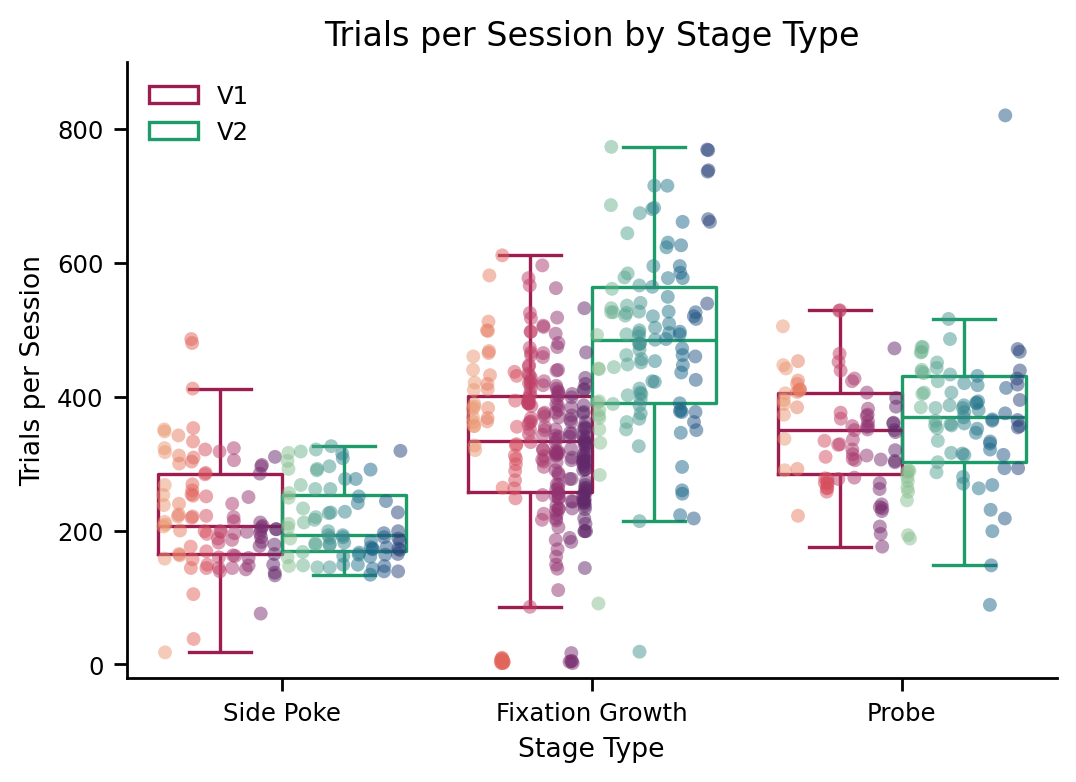

In [291]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

box_strip_v1_vs_v2(
    trials_df,
    x="stage_type",
    order=["spoke", "grow_fix", "probe"],
    y="n_trials",
    ax=ax,
    hue_type="animal",
    alpha=0.5,
    ylabel="Trials per Session",
    xlabel="Stage Type",
)

_ = ax.set_xticks([0, 1, 2])
_ = ax.set_xticklabels(STAGE_LABELS)
ax.set(ylim=(-20, 900))
ax.set_title("Trials per Session by Stage Type", fontsize=12)

In [156]:
compare_v1_v2_by_stage_multi_sample(trials_df, metric_col="n_trials")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


,stage,test_type,test_statistic,p_val_raw,p_val_adj,residuals_normal,reject_H0
0,spoke,mixedlm_random_intercept,-0.809174,0.418415,0.418415,False,False
1,grow_fix,mixedlm_random_intercept,3.717078,0.000202,0.000605,False,True
2,probe,mixedlm_random_intercept,1.334493,0.182042,0.364085,False,False


In [157]:
summary_trials = (
    trials_df.groupby(["animal_id", "stage_type", "fix_experiment"])["n_trials"]
    .mean()
    .reset_index()
)
compare_v1_v2_by_stage(summary_trials, metric_col="n_trials")

,stage,test_type,test_statistic,p_val_raw,p_val_adj,reject_H0,normality_V1,normality_V2,n_V1,n_V2
0,spoke,welch_t,0.500023,0.624451,0.961415,False,True,True,9,9
1,grow_fix,welch_t,-3.706287,0.001924,0.005773,True,True,True,9,9
2,probe,mannwhitney,28.000000,0.480708,0.961415,False,True,False,8,9


# 4. Rig Switches

Need to load in the data in fetch data, write a load function then map the date to the stage type with a merge and then compute the number of rig switches (and do that by stage type and then plot for each animal).


In [196]:
# Sort the dataframe by animal_id and date
ddf_sorted = ddf.sort_values(["animal_id", "date"])


# Define a function to count rig switches for a series
def count_switches(rig_series):
    # Compare each row to the previous row
    # (rig_series != rig_series.shift(1)) returns True for a change.
    # Subtract 1 to ignore the first row's NaN comparison.
    return (rig_series != rig_series.shift(1)).sum() - 1


# Group by animal_id and aggregate:
# - For 'rig', apply the count_switches function.
# - For 'stage_type' and 'fix_experiment', take the first value (adjust if needed).
rig_switch_df = (
    ddf_sorted.groupby(["animal_id", "stage_type"])
    .agg(
        {
            "rigid": count_switches,
            "fix_experiment": "first",
        }
    )
    .reset_index()
)
rig_switch_df.rename(columns={"rigid": "n_rig_switches"}, inplace=True)
rig_switch_df["n_rigs"] = rig_switch_df["n_rig_switches"] + 1

# remove r044
rig_switch_df = rig_switch_df.query("animal_id != 'R044'")

Text(0.5, 1.0, 'Number of Rigs Used by Stage Type')

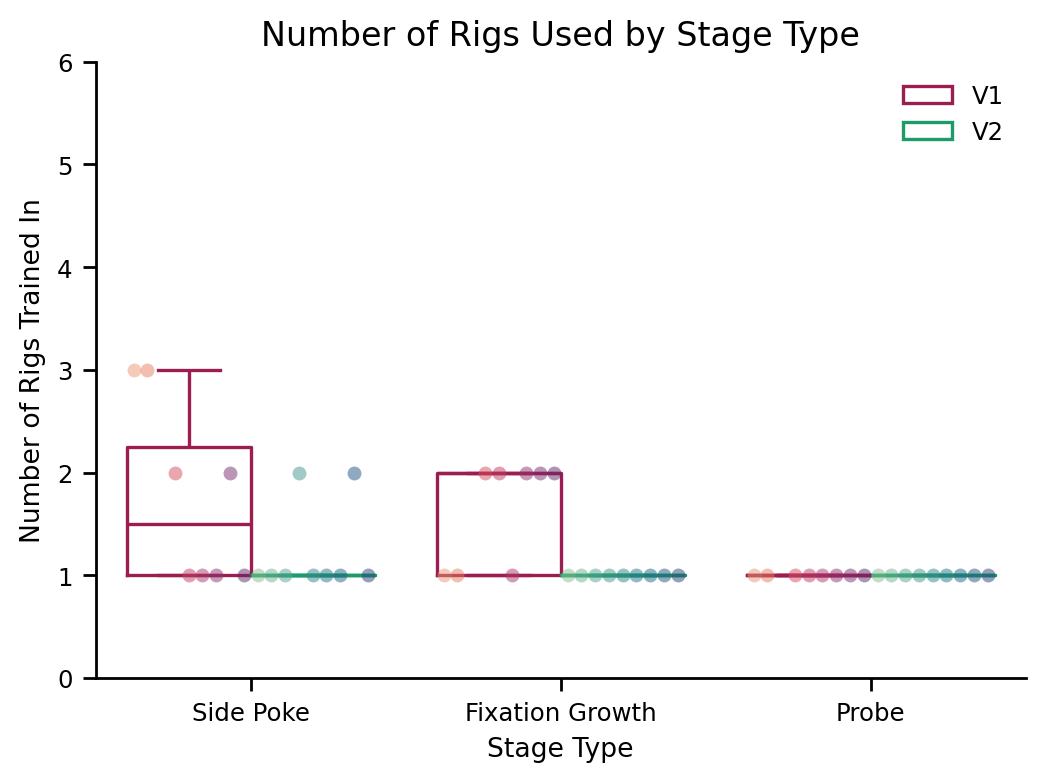

In [292]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

box_strip_v1_vs_v2(
    rig_switch_df,
    x="stage_type",
    order=["spoke", "grow_fix", "probe"],
    y="n_rigs",
    ax=ax,
    hue_type="animal",
    alpha=0.5,
    ylabel="Number of Rigs Trained In",
    xlabel="Stage Type",
)

_ = ax.set_xticks([0, 1, 2])
_ = ax.set_xticklabels(STAGE_LABELS)
_ = ax.set_ylim(0, 6)
ax.set_title("Number of Rigs Used by Stage Type", fontsize=12)

In [198]:
compare_v1_v2_by_stage(rig_switch_df, metric_col="n_rigs")

/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/jessbreda/anaconda3/envs/behav_viz/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,stage,test_type,test_statistic,p_val_raw,p_val_adj,reject_H0,normality_V1,normality_V2,n_V1,n_V2
0,spoke,mannwhitney,48.0,0.191236,0.382471,False,False,False,8,9
1,grow_fix,mannwhitney,58.5,0.007412,0.022235,True,False,True,8,9
2,probe,welch_t,NaN,NaN,NaN,False,True,True,8,9


# 5. Stage Progression


In [277]:
def plot_stage(
    trials_df,
    ax=None,
    title="",
    x_var="date",
    ylim=None,
    rotate_x_labels=False,
    hue=None,
    relative_to_stage=None,
    xlabel="",
    legend_title="",
    **kwargs,
):
    """
    Plot stage over group variable.

    Having the group variable allows you to group by other
    things like "start_date" if you want to try and make a plot
    with multiple animals that started at different times.

    params
    ------
    trials_df : pd.DataFrame
        trials dataframe with columns `date`, `stage` with trials as row index
    ax : matplotlib.axes.Axes (optional, default = None)
        axes to plot on
    title : str (optional, default = "")
        title for the plot
    group : str (optional, default = "date")
        column to group by for x axis (e.g. "date", "start_date")
    ylim : tuple (optional, default = None)
        y-axis limits
    rotate_x_labels : bool (optional, default = False)
        whether to rotate the x-axis labels or not
    hue : str (optional, default = None)
        column to color by
    relative_to_stage : str (optional, default = None)
        column to compute days relative to
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 3), dpi=300)

    if relative_to_stage and x_var == "date":
        trials_df = u.compute_days_relative_to_stage(
            trials_df, stage=relative_to_stage
        ).reset_index()
        x_var = f"days_relative_to_stage_{relative_to_stage}"

    if hue:
        cols = [x_var, hue]
    else:
        cols = [x_var]

    plot_df = trials_df.groupby(cols, observed=True).stage.mean().reset_index()

    sns.lineplot(
        data=plot_df,
        y="stage",
        x=x_var,
        hue=hue,
        drawstyle="steps-post",
        ax=ax,
        marker="o",
        **kwargs,
    )

    # aesthetics
    if rotate_x_labels:
        ax.tick_params(axis="x", rotation=45)

    if ylim:
        ylim = ylim
        yticks = range(ylim[0], ylim[1] + 1)
    else:
        max_stage = int(trials_df.stage.max())
        ylim = (0, max_stage + 1)
        yticks = range(max_stage + 1)

    ax.set(
        ylabel="Stage #",
        xlabel=xlabel,
        title=title,
        ylim=ylim,
        yticks=yticks,
    )
    ax.legend(
        title=legend_title,
    )
    ax.grid()

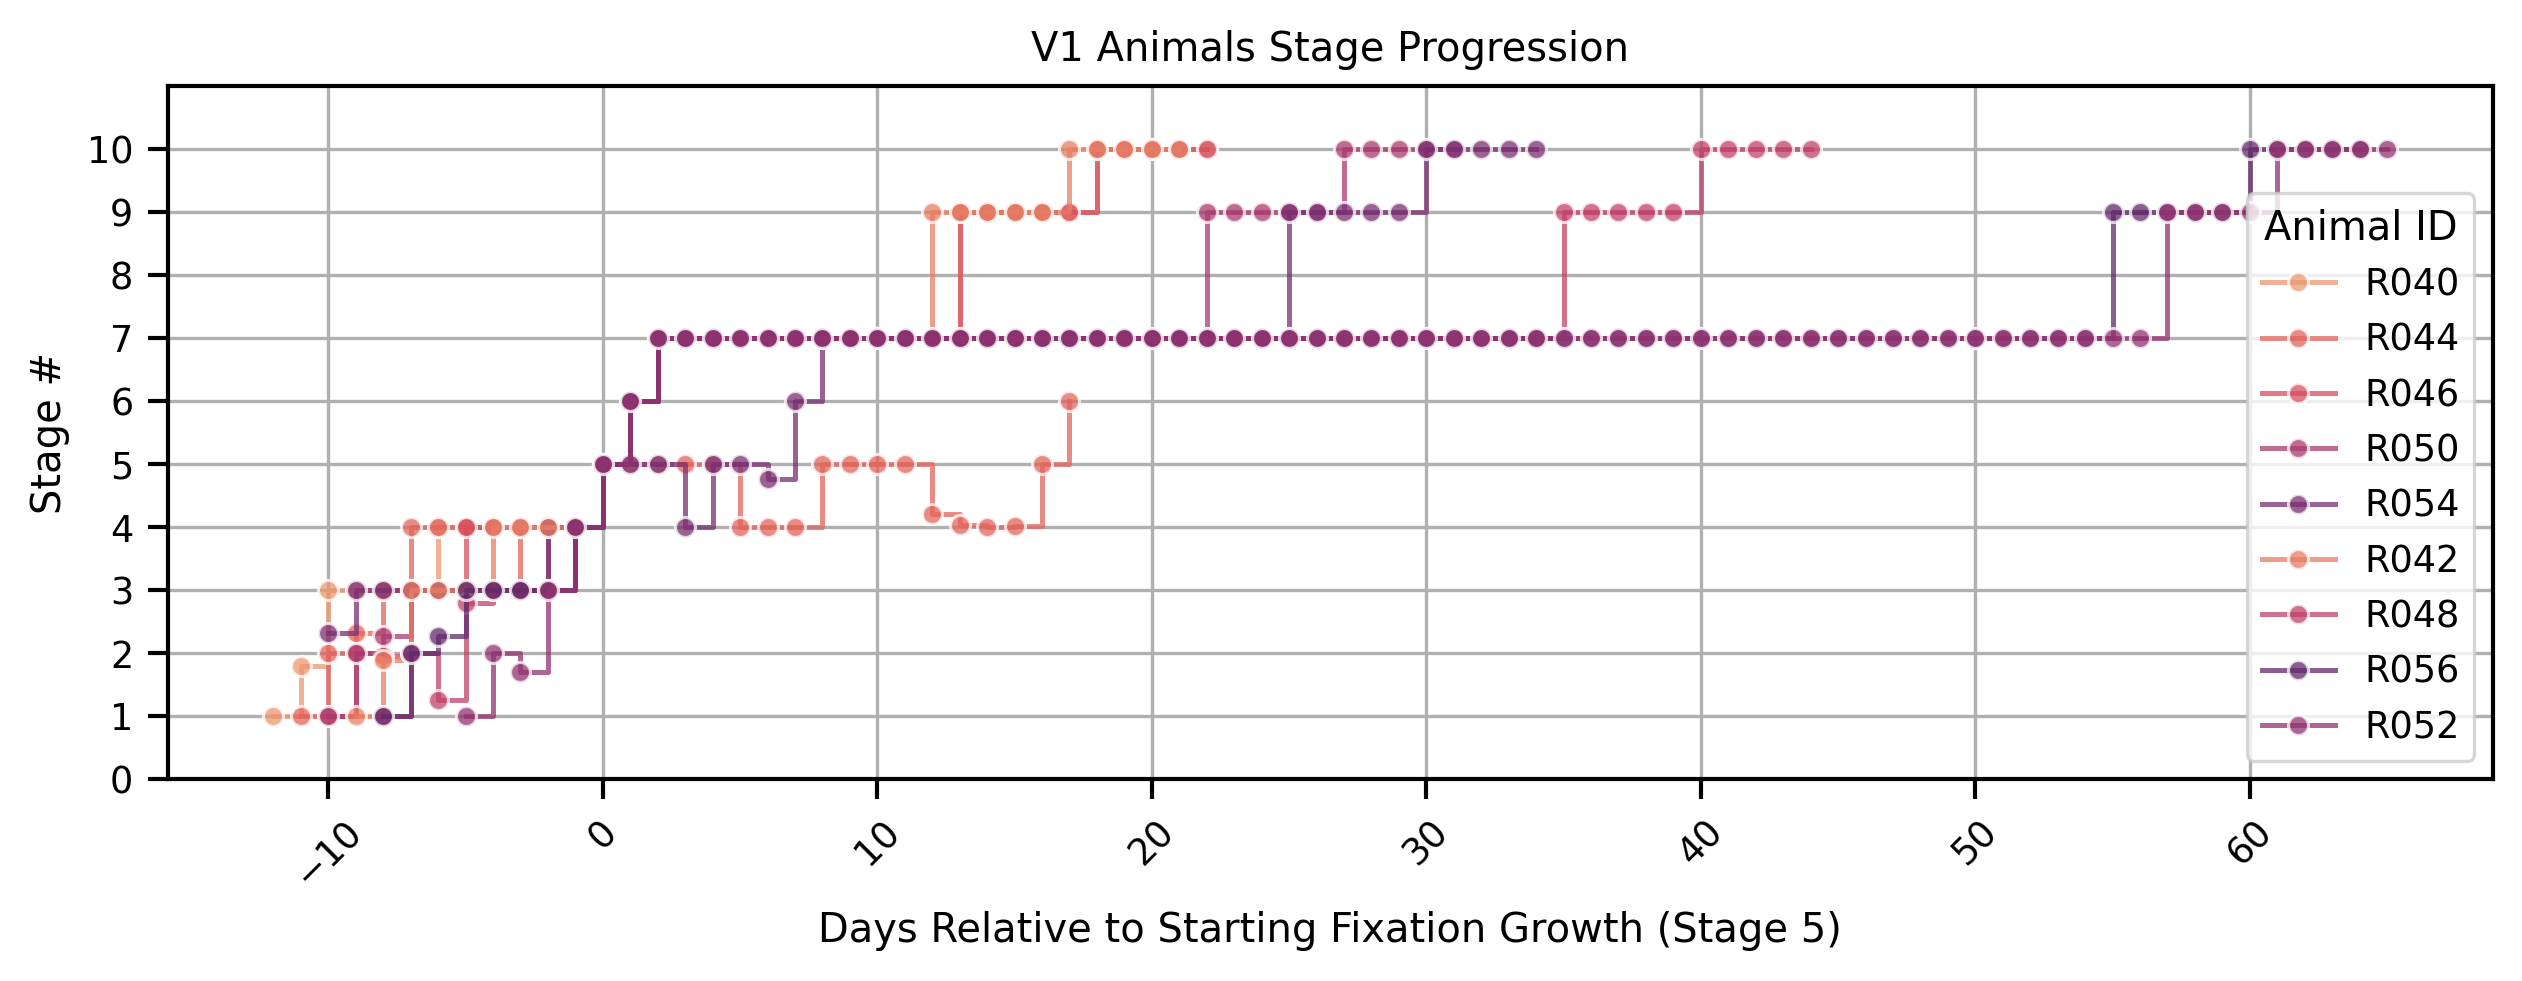

In [278]:
plot_stage(
    tdf.query("fix_experiment == 'V1' and stage < 11").copy(),
    rotate_x_labels=True,
    hue="animal_id",
    palette=c.ANIMAL_PALETTE,
    alpha=0.75,
    relative_to_stage=5,
    xlabel="Days Relative to Starting Fixation Growth (Stage 5)",
    title="V1 Animals Stage Progression",
    legend_title="Animal ID",
)

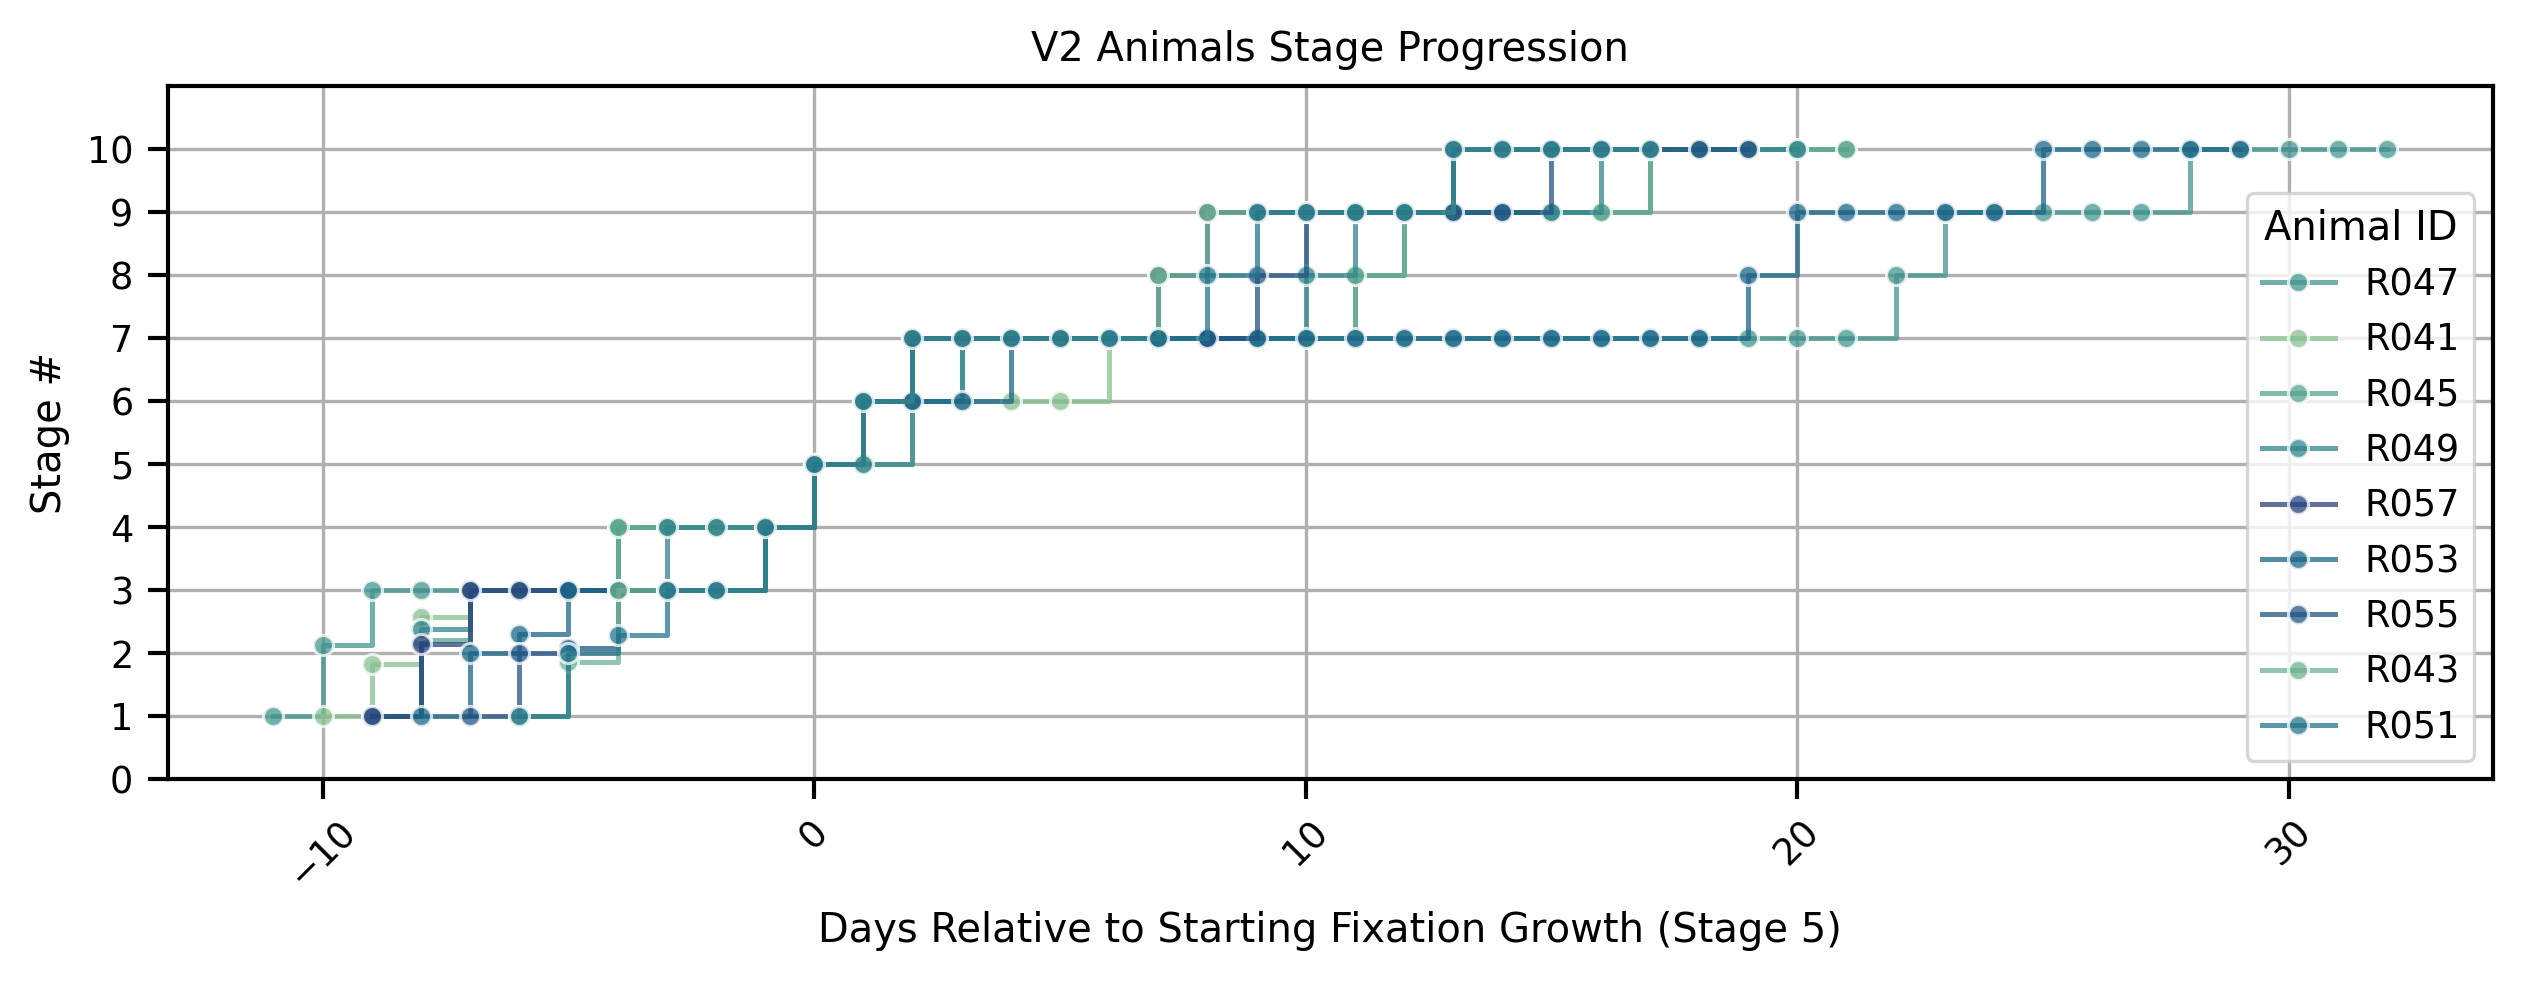

In [279]:
plot_stage(
    tdf.query("fix_experiment == 'V2'").copy(),
    rotate_x_labels=True,
    hue="animal_id",
    palette=c.ANIMAL_PALETTE,
    alpha=0.75,
    relative_to_stage=5,
    xlabel="Days Relative to Starting Fixation Growth (Stage 5)",
    title="V2 Animals Stage Progression",
    legend_title="Animal ID",
)

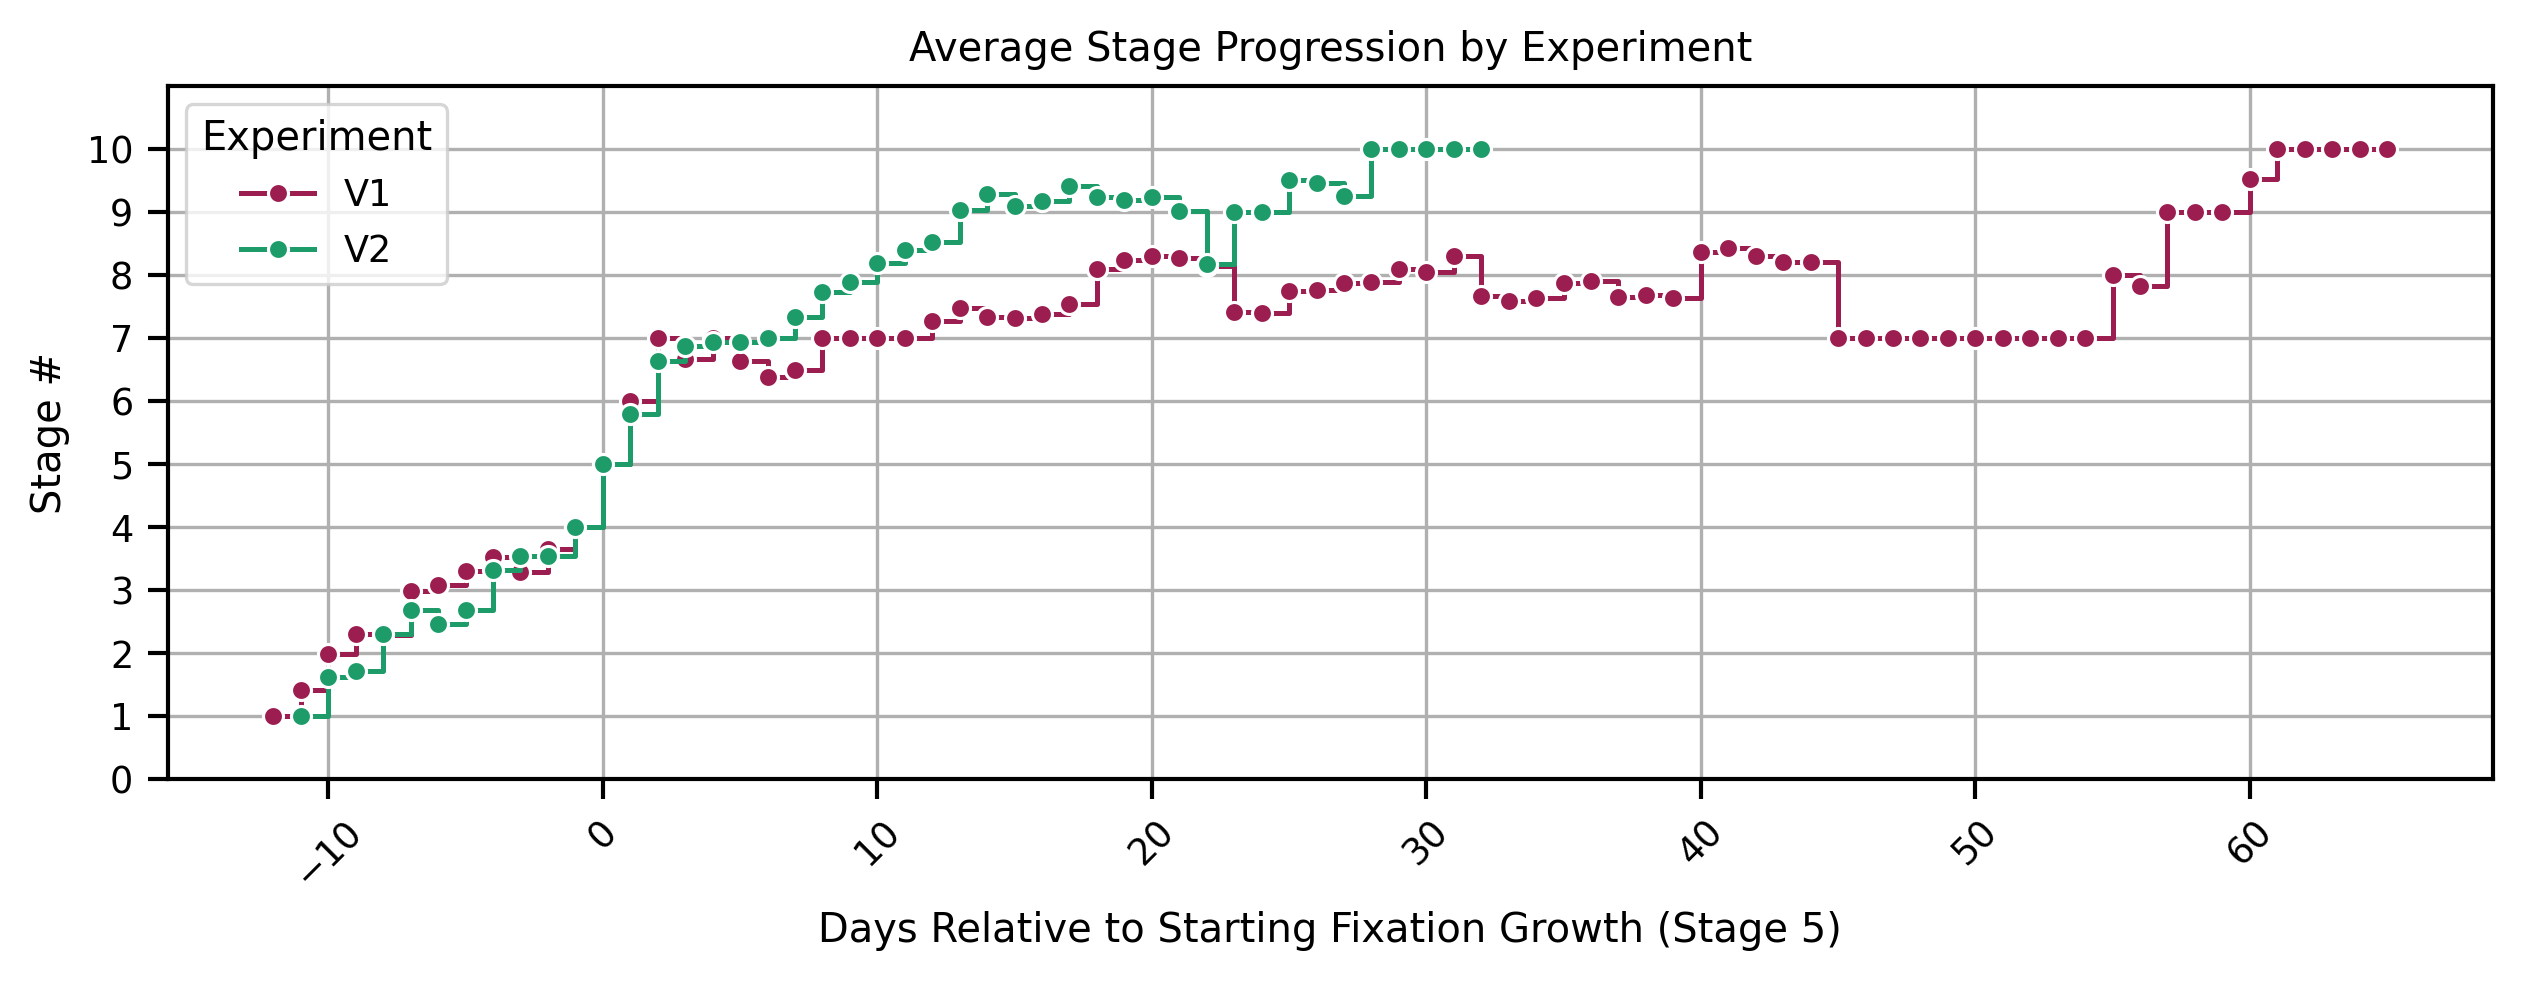

In [280]:
plot_stage(
    tdf,
    rotate_x_labels=True,
    hue="fix_experiment",
    palette=c.EXP_PALETTE,
    relative_to_stage=5,
    xlabel="Days Relative to Starting Fixation Growth (Stage 5)",
    title="Average Stage Progression by Experiment",
    legend_title="Experiment",
)